In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import progressbar
from sklearn import preprocessing


from pathlib import Path
import ffmpeg
from os.path import isfile, join
from os import listdir

In [2]:
all_games = pd.read_csv('all_games.csv')
all_games.drop(all_games.columns[[0,1]],1,inplace=True)

In [3]:
all_games_og = pd.read_csv('all_games_other_games.csv')
all_games_og.drop(all_games_og.columns[[0,1]],1,inplace=True)

In [4]:
all_games_ad = pd.concat([all_games, all_games_og])

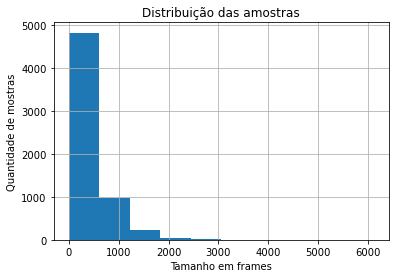

In [5]:
fig, axs = plt.subplots()

# We can set the number of bins with the `bins` kwarg
plt.hist(all_games_ad['interval_frame_size'])
plt.title('Distribuição das amostras')
plt.grid(True)
plt.ylabel('Quantidade de mostras')
plt.xlabel('Tamanho em frames')
plt.savefig('distribuicao_amostras.png')
#plt.xticks(x2)

In [6]:
all_games_ad[all_games_ad['interval_frame_size'] >= 500].target.value_counts()

0.0    1456
1.0     114
Name: target, dtype: int64

### Imagem dos jogadores em campo 

In [7]:
import networkx as nx
import scipy.spatial
import math
import gc

In [8]:
def create_graph():
    players_data = players_positions_FETW.copy()
    players_data = players_data.drop([0],axis=1)
    players_data.columns = [i+1 for i in range(len(players_data.columns))]
    players_data = players_data.transpose()

    def create_graph_nodes(row):
        position_list=[]
        G = nx.Graph()
        k = 0
        j = 0
        #Add the node "j", containing the argument "pos=x_coord, y_coord, for the fist team (k = 0 to 22)"
        while k < 28:
            #Apend the coordnates of the player to the postion list (will be used on a future opertion)
            #if (row[k] > -100) & (row[k+1] > -100):
            position_list.append([row[k],row[k+1]])
            G.add_node(j, pos=(row[k],row[k+1]))
            j = j+1
            k = k+2
        #Apend the graph to the graph list
        graph_list.append(G)
        j=0
        # apend the position list for the current frame to the list of positions lists (will be used on a future opertion)
        group_of_position_lists.append(position_list)

        #Repeat all for the second team"
        G = nx.Graph()
        position_list=[]
        while k < 60:
            #if (row[k] > -100) & (row[k+1] > -100):
            position_list.append([row[k],row[k+1]])
            G.add_node(j, pos=(row[k],row[k+1]))
            j = j+1
            k = k+2
        graph_list.append(G)
        #will be used to generate delaunay trianges
        group_of_position_lists.append(position_list)
        return 0

    #Transform the dataset into a numpy_array and call the function above
    x= players_data.values
    np.apply_along_axis(create_graph_nodes, 0, x)

    #create a list of tuples, containing player positions
    for a_graph in (graph_list):
        list_pos.append(nx.get_node_attributes(a_graph,'pos'))

    for pos_list in (group_of_position_lists):
        triang_del_list.append(scipy.spatial.Delaunay(pos_list))

    #create edges from delaunay triangles

    # for each set of triangles
    i = 0
    for delTri in (triang_del_list):
        edges = set()
        # for each Delaunay triangle
        for n in range(delTri.nsimplex):
        # for each edge of the triangle
        # sort the vertices
        # (sorting avoids duplicated edges being added to the set)
        # and add to the edges set
            edge = sorted([delTri.vertices[n,0], delTri.vertices[n,1]])
            edges.add((edge[0], edge[1]))
            edge = sorted([delTri.vertices[n,0], delTri.vertices[n,2]])
            edges.add((edge[0], edge[1]))
            edge = sorted([delTri.vertices[n,1], delTri.vertices[n,2]])
            edges.add((edge[0], edge[1]))
        graph = nx.Graph(list(edges)) 
        nx.set_node_attributes(graph, list_pos[i], 'pos')
        graph_group.append(graph)
        i = i+1

    # Delete edges from players with adversaries close (pos dif < 0.5) to them
    i=0
    #for i in progressbar.progressbar(range(len(list_pos))):
    while i < len(list_pos):
        for pos_id, pos_values in list_pos[i].items():
            for pos_adv, pos_values_adv in list_pos[i+1].items():
                #Get distance on the x axis
                dist_x = pos_values[0] - pos_values_adv[0]
                 #Get distance on the y axis
                dist_y = pos_values[1] - pos_values_adv[1]
                #Calculate distance
                dist_total = math.hypot(dist_y,dist_x)
                # if distance <0.5, remove the all edges by deleting and re-adding the node
                # do it for graph of both teams
                if dist_total < 0.5:
                    if graph_group[i].has_node(pos_id):
                        m_node = graph_group[i].nodes[pos_id]
                        graph_group[i].remove_node(pos_id)
                        graph_group[i].add_node(pos_id, pos=pos_values)

                    if graph_group[i+1].has_node(pos_id) & graph_group[i+1].has_node(pos_adv):
                        m_node_adv = graph_group[i+1].nodes[pos_id]
                        graph_group[i+1].remove_node(pos_adv)
                        graph_group[i+1].add_node(pos_adv, pos=pos_values_adv)
        i = i+2

In [9]:
def create_digraph():
    players_data = players_positions_FETW.copy()
    players_data = players_data.drop([0],axis=1)
    players_data.columns = [i+1 for i in range(len(players_data.columns))]
    players_data = players_data.transpose()

    def create_graph_nodes(row):
        position_list=[]
        G = nx.DiGraph()
        k = 0
        j = 0
        #Add the node "j", containing the argument "pos=x_coord, y_coord, for the fist team (k = 0 to 22)"
        while k < 28:
            #Apend the coordnates of the player to the postion list (will be used on a future opertion)
            if (row[k] > -100) & (row[k+1] > -100):
                position_list.append([row[k],row[k+1]])
                G.add_node(j, pos=(row[k],row[k+1]))
            j = j+1
            k = k+2
        #Apend the graph to the graph list
        graph_list.append(G)
        j=0
        # apend the position list for the current frame to the list of positions lists (will be used on a future opertion)
        group_of_position_lists.append(position_list)

        #Repeat all for the second team"
        G = nx.DiGraph()
        position_list=[]
        while k < 60:
            if (row[k] > -100) & (row[k+1] > -100):
                position_list.append([row[k],row[k+1]])
                G.add_node(j, pos=(row[k],row[k+1]))
            j = j+1
            k = k+2
        graph_list.append(G)
        #will be used to generate delaunay trianges
        group_of_position_lists.append(position_list)
        return 0

    #Transform the dataset into a numpy_array and call the function above
    x= players_data.values
    np.apply_along_axis(create_graph_nodes, 0, x)

    #create a list of tuples, containing player positions
    for a_graph in (graph_list):
        list_pos.append(nx.get_node_attributes(a_graph,'pos'))

    for pos_list in (group_of_position_lists):
        triang_del_list.append(scipy.spatial.Delaunay(pos_list))

    #create edges from delaunay triangles

    # for each set of triangles
    i = 0
    for delTri in (triang_del_list):
        edges = set()
        # for each Delaunay triangle
        for n in range(delTri.nsimplex):
        # for each edge of the triangle
        # sort the vertices
        # (sorting avoids duplicated edges being added to the set)
        # and add to the edges set
            edge = sorted([delTri.vertices[n,0], delTri.vertices[n,1]])
            edges.add((edge[0], edge[1]))
            edge = sorted([delTri.vertices[n,0], delTri.vertices[n,2]])
            edges.add((edge[0], edge[1]))
            edge = sorted([delTri.vertices[n,1], delTri.vertices[n,2]])
            edges.add((edge[0], edge[1]))
        graph = nx.Graph(list(edges)) 
        nx.set_node_attributes(graph, list_pos[i], 'pos')
        graph_group.append(graph)
        i = i+1

    # Delete edges from players with adversaries close (pos dif < 0.5) to them
    i=0
    #for i in progressbar.progressbar(range(len(list_pos))):
    while i < len(list_pos):
        for pos_id, pos_values in list_pos[i].items():
            for pos_adv, pos_values_adv in list_pos[i+1].items():
                #Get distance on the x axis
                dist_x = pos_values[0] - pos_values_adv[0]
                 #Get distance on the y axis
                dist_y = pos_values[1] - pos_values_adv[1]
                #Calculate distance
                dist_total = math.hypot(dist_y,dist_x)
                # if distance <0.5, remove the all edges by deleting and re-adding the node
                # do it for graph of both teams
                if dist_total < 0.5:
                    if graph_group[i].has_node(pos_id):
                        m_node = graph_group[i].nodes[pos_id]
                        graph_group[i].remove_node(pos_id)
                        graph_group[i].add_node(pos_id, pos=pos_values)

                    if graph_group[i+1].has_node(pos_id) & graph_group[i+1].has_node(pos_adv):
                        m_node_adv = graph_group[i+1].nodes[pos_id]
                        graph_group[i+1].remove_node(pos_adv)
                        graph_group[i+1].add_node(pos_adv, pos=pos_values_adv)
        i = i+2

In [10]:
def remove_node_graph_group(graph_number, graph_group):
    node_to_remove = []##Lista com os nós com distancia errada
    
    for node in graph_group[graph_number].nodes():
       
        try: 
            if -9999 in graph_group[graph_number].nodes[node]['pos']:
                node_to_remove.append(node)
            
        except KeyError:
             node_to_remove.append(node)
                
    for node in node_to_remove:
        graph_group[graph_number].remove_node(node)

In [11]:
#Função que pega a posição dos jogadores só dos intervalos de FETW
def get_FETW_interval(FETW_ini,FETW_end):
    list_player.append(players_positions.iloc[FETW_ini:FETW_end])

In [12]:
partidas = pd.read_csv('all_games_ad_FETW.csv')['partida'].unique()

In [13]:
partidas = partidas[1:2]

In [14]:
for partida in progressbar.progressbar(partidas):  
    
    graph_list_BPI = []#Lista da dos grafos para cada BPI
    
    #Mostra qual partida está sendo analisada
    print(partida)

    #Lendo posição dos jogadores
    players_positions = pd.read_csv('Jogos\\'+partida+'suav.2d', sep =('\s+'), header=None)

    list_player = [] #Lista com as posição de FETW
    players_positions_FETW = pd.DataFrame() #DataFrame de posição dos jogadores (considerando somente FETW)

    #Define o conjunto de dados
    game_1 = all_games[(all_games.partida == partida) & (all_games.interval_frame_size >= 500)]
    #game_1 = all_games[(all_games.partida == partida)]

    #Extraindo in
    game_1.apply(lambda x: get_FETW_interval(int(x.frame),int(x.FETW_end)),1)

    #Criando Dataframe com todas as posições de FETW
    #for jogo in list_player:
        #players_positions_FETW = pd.concat([players_positions_FETW, jogo])

    #Loop para gerar um arquivo para cada FETW, e dps com data arquivo gerar uma imagem
    FETW_count = 0
    for jogo in progressbar.progressbar(list_player):

        #Cria o dataframe dos dados do FETW atual
        players_positions_FETW = pd.DataFrame(jogo)

        #Mostra qual o FETW atual
        #print(FETW_count)

        #Define variaveis globais
        graph_list = []
        group_of_position_lists = []
        list_pos = []
        triang_del_list = []
        graph_group = []
        bet_cen_matrix_t1 = []
        bet_cen_matrix_t2 = []

        #Métos que geram os nodes
        create_graph()
        #create_digraph()
        graph_list_BPI.append(graph_group)

        #Liberando espaço
        #del triang_del_list
        del group_of_position_lists
        del list_pos
        gc.collect()

        FETW_count += 1

  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

REDSCAT2


100% (66 of 66) |########################| Elapsed Time: 0:00:58 Time:  0:00:58
100% (1 of 1) |##########################| Elapsed Time: 0:01:02 Time:  0:01:02


## Lendo métricas de grafo 

Ler métricas de grafo <br>
Normalizar o valor da métrica <br>
Lista com os valores conforme o loop ocorre o tamanho do nó é o valor da métrica <br>

In [15]:
path_grafo_metric = 'grafo_all_bases/REDSCAT2/'

In [16]:
# Le os arquivos das métricas extraidas
def read_files_on_fold(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    return onlyfiles

In [17]:
# Lê os arquivos de métricas de grafos 
def read_dataframe_metric(file, mypath):
    #metric = pd.read_csv('grafo//'+ partida+ '/'+graph_metrics[metric_count]+'.csv')
    metric = pd.read_csv(mypath+'/'+str(file))
    metric.drop(metric.columns[[0]],1, inplace= True)
    metric.fillna(0,inplace= True)
    
    return metric

In [18]:
files = read_files_on_fold(path_grafo_metric)

In [19]:
# Pega a métrica escolhida para cada equipe (t1 e t2)
bpt_get_metrics = 60
for file in progressbar.progressbar(files):
    if (file.split('_')[1] == 'clusteringcoeffi') and (file.split('_')[0] == str(bpt_get_metrics)):
        if 't1' in file.split('_')[2]:
            metric_t1 = read_dataframe_metric(file, path_grafo_metric)
        elif 't2' in file.split('_')[2]:
            metric_t2 = read_dataframe_metric(file, path_grafo_metric)
        

100% (1452 of 1452) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


In [20]:
# Normalizando os dados das métricas (para os nodes ficarem proporcionais no plot)
min_max_scaler = preprocessing.MinMaxScaler()

metric_1_scaled = min_max_scaler.fit_transform(metric_t1)
metric_2_scaled = min_max_scaler.fit_transform(metric_t2)

## Construindo imagem

In [21]:
def set_one_edge(H):
    for i in H.nodes():
        H.remove_edges_from(list(H.in_edges(i))[1:])
    return H

In [22]:
def graph_image_generate(graph_group, graf_even, graf_odd, bpi_count, FETW, edges=False,node_proportion=False):
    #https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
    #Lib q plota os grafos
    
    remove_node_graph_group(graf_even, graph_group) # Remove node sem posição
    remove_node_graph_group(graf_odd, graph_group)
    
    #h1 = graph_group[graf_odd].to_directed() #Transforma o grafo em direcionado
    #h2 = graph_group[graf_even].to_directed()
    
    h1 = graph_group[graf_odd]
    h2 = graph_group[graf_even]
    h3 = ball_nodes[bpi_count]
    
    #h1 = set_one_edge(h1) #Remove os edges deixando somente a primeira
    #h2 = set_one_edge(h2)
    
    my_pos=nx.get_node_attributes(h1,'pos')#Pega as posições do grafo
    my_pos_adv=nx.get_node_attributes(h2,'pos')
    ball_pos = nx.get_node_attributes(h3,'pos')
    
    img = plt.imread("soccer_field.png")#Carrega imagem de fundo

    fig, ax = plt.subplots(figsize=(12,8))#Tamanho da plotagem
    ax.imshow(img, extent=[-5,110, -5, 70])#Tamanho do campo em pixels

    #print(len(h1.nodes))
    #print(len(h2.nodes))
    
    # Gera as arestas e altera o tamanho do nó depedendo do valor da métrica
    if node_proportion & edges:
        # print('Grafo com edges')
        nx.draw_networkx(h1, my_pos, nodelist = sorted(h1.nodes),
                         node_color="#06daf9",edge_color="blue",label='Equipe 1',font_size=15,
                         edgelist=h1.edges, node_size=[v * 300 for v in metric_1_scaled[bpi_count] + 1])

        nx.draw_networkx(h2, my_pos_adv, nodelist = sorted(h2.nodes),
                         node_color="#d73502", edge_color="red",label='Equipe 2',font_size=15,
                         edgelist=h2.edges, node_size=[v * 300 for v in metric_2_scaled[bpi_count] + 1])
    
    elif edges:
        nx.draw_networkx(h1, my_pos, nodelist = sorted(h1.nodes),
                         node_color="#06daf9",edge_color="blue",label='Equipe 1',font_size=15,
                         edgelist=h1.edges)

        nx.draw_networkx(h2, my_pos_adv, nodelist = sorted(h2.nodes),
                         node_color="#d73502", edge_color="red",label='Equipe 2',font_size=15,
                         edgelist=h2.edges)
    # Caso contrário plota somente os nós
    else:
        # print('Grafo sem edges')
        nx.draw_networkx(h1, my_pos, nodelist = sorted(h1.nodes),edgelist=[],
                         node_color="#06daf9",edge_color="blue",label='Equipe 1',font_size=15)

        nx.draw_networkx(h2, my_pos_adv, nodelist = sorted(h2.nodes),edgelist=[],
                         node_color="#d73502", edge_color="red",label='Equipe 2',font_size=15)
        
    nx.draw_networkx(h3, ball_pos, node_size=100,
                     node_color="#000000", edge_color="black",label='Bola',font_size=15)

    ax.legend()
    
    if edges:
        path = 'ffmpeg_fetws/graph_to_ffmpeg_REDSCAT2_edges_'+str(FETW)+'/'
    else:
        path = 'ffmpeg_fetws/graph_to_ffmpeg_REDSCAT2_'+str(FETW)+'/'
        
    Path(path).mkdir(parents=True, exist_ok=True)
    #fig.savefig(path+'img'+str(bpi_count)
               # +'.png',transparent=True)#, format='svg')#Salva a imagem em SVG transparentere
    
    #ax.title.set_text("Distribuição dos jogadores em campo")
    
    #fig.clear()

In [23]:
def plot_generate(graph_group, graf_even, graf_odd, bpi_count):
    #https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html
    #Lib q plota os grafos
    
    remove_node_graph_group(graf_even, graph_group) # Remove node sem posição
    remove_node_graph_group(graf_odd, graph_group)
    
    #h1 = graph_group[graf_odd].to_directed() #Transforma o grafo em direcionado
    #h2 = graph_group[graf_even].to_directed()
    
    h1 = graph_group[graf_odd]
    h2 = graph_group[graf_even]
    h3 = ball_nodes[bpi_count]
    
    #h1 = set_one_edge(h1) #Remove os edges deixando somente a primeira
    #h2 = set_one_edge(h2)
    
    my_pos=nx.get_node_attributes(h1,'pos')#Pega as posições do grafo
    my_pos_adv=nx.get_node_attributes(h2,'pos')
    ball_pos = nx.get_node_attributes(h3,'pos')
    
    img = plt.imread("soccer_field.png")#Carrega imagem de fundo

    fig, ax = plt.subplots(figsize=(12,8))#Tamanho da plotagem
    ax.imshow(img, extent=[-5,110, -5, 70])#Tamanho do campo em pixels

    #print(len(h1.nodes))
    #print(len(h2.nodes))
    
    # Gera as arestas e altera o tamanho do nó depedendo do valor da métrica

    # print('Grafo com edges')
    nx.draw_networkx(h1, my_pos, nodelist = sorted(h1.nodes),
                     node_color="#06daf9",edge_color="blue",label='Team 1',font_size=15,
                     edgelist=h1.edges)

    nx.draw_networkx(h2, my_pos_adv, nodelist = sorted(h2.nodes),
                     node_color="#d73502", edge_color="red",label='Team 2',font_size=15,
                     edgelist=h2.edges)
 
    ax.legend()  
    ax.title.set_text("Distribuição dos jogadores em campo")

In [24]:
graph_list_BPI[60][100].nodes

NodeView((3, 4, 7, 5, 0, 2, 8, 1, 6, 11, 13, 9))

In [25]:
sorted(graph_list_BPI[60][100].nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13]

In [26]:
def generate_imagens_to_ffmpeg(bpi, edges=False):
    
    #comando para rodar e gerar um video com todas as imagens .png da pasta
    #ffmpeg -f image2 -i img%d.png test.mp4
    
    count = 0
    for graph in range(int(len(graph_list_BPI[bpi])/2)-1):
        graph_image_generate(graph_list_BPI[bpi], count, count+1, graph, bpi, edges)
        #print(count)
        count+=2
        #graph_image_generate()

In [27]:
def generate_imagens_to_ffmpeg_all_game():
    
    #comando para rodar e gerar um video com todas as imagens .png da pasta
    #ffmpeg -f image2 -i img%d.png test.mp4
    
    all_game_frame_count = 0
    for bpi in progressbar.progressbar(range(len(graph_list_BPI))):
        count = 0
        for graph in range(int(len(graph_list_BPI[bpi])/2)):
            graph_image_generate(graph_list_BPI[bpi], count, count+1, all_game_frame_count, FETW)
            #print(count)
            count+=2
            #graph_image_generate()
            all_game_frame_count+=1

In [28]:
# Função para gerar video utilizando ffmpeg
def create_video(path, FETW, edges=False):
    print(edges)
    if edges:
        (
            ffmpeg
            # Pasta com imagens e taxa de frames
            .input('ffmpeg_fetws/graph_to_ffmpeg_REDSCAT2_edges_'+str(FETW)+'/img%d.png',  framerate=25)
            .filter("scale", size='hd1080', force_original_aspect_ratio='increase')
            # Local onde será salvo o vídeo
            .output(path+'REDSCAT2_edges_'+str(FETW)+'.mp4')
            .run()
        )
    else:
        (
            ffmpeg
            # Pasta com imagens e taxa de frames
            .input('ffmpeg_fetws/graph_to_ffmpeg_REDSCAT2_'+str(FETW)+'/img%d.png',  framerate=25)
            .filter("scale", size='hd1080', force_original_aspect_ratio='increase')
            # Local onde será salvo o vídeo
            .output(path+'REDSCAT2_'+str(FETW)+'.mp4')
            .run()
        )

In [29]:
#graph_list_BPI[190][0]
#edgelist=graph_group[0].edges

In [30]:
#fig, ax = plt.subplots(figsize=(12,8))#Tamanho da plotagem
#img = plt.imread("soccer_field.png")#Carrega imagem de fundo
#ax.imshow(img, extent=[-5,110, -2, 65])#Tamanho do campo em pixels
#nx.draw_networkx(graph_list[1], nx.get_node_attributes(graph_list[1],'pos'),node_color="#d73502",edge_color="red", node_size=[v * 300 for v in metric_1_scaled[0] + 1])
#nx.draw_networkx(graph_list[0], nx.get_node_attributes(graph_list[0],'pos'),node_color="#06daf9", edge_color="blue", node_size=[v * 300 for v in metric_2_scaled[0] + 1])

In [31]:
# nx.get_node_attributes(graph_list[0],'pos')
# list_player[60]
# game_2[game_2['frame'] == 79825]

## Lendo possição da bola

In [32]:
ball_possition = pd.read_csv('ball_position/ball_position_REDSCAT2.csv')

In [33]:
#Possições do BPI 122 (contagem geral) 60 (contagem da partida)

#ball_posi_bpi20 = ball_possition.iloc[79825:79992,2:].copy()#122
#ball_posi_bpi20 = ball_possition.iloc[57740:57907,2:].copy()#106
ball_posi_bpi20 = ball_possition.iloc[81267:81433,2:].copy()#60 local
#ball_posi_bpi20 = ball_possition.iloc[17136:17303,2:].copy()#75
#ball_posi_bpi20 = ball_possition.copy()
xball = ball_posi_bpi20.values

In [34]:
ball_nodes = []
#node_count = 0
for bpi_ball in xball:
    G = nx.Graph()
    G.add_node('B', pos=(bpi_ball[0],bpi_ball[1]))
    ball_nodes.append(G)
    #print(bpi_ball)
    #node_count+=1

In [35]:
#graph_image_generate(graph_list_BPI[60], 100, 101, 0)

In [36]:
#graph_image_generate(graph_list_BPI[20],2,3,0)

In [37]:
# graph_image_generate(graph_list_BPI[bpi], count, count+1, all_game_frame_count, FETW)

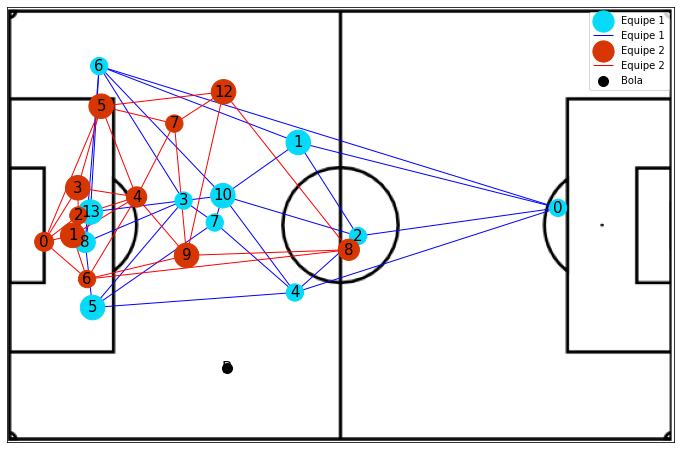

In [38]:
graph_image_generate(graph_list_BPI[28], 0,1,0,0, edges=True, node_proportion=True)
# plt.title('Centralidade de cada jogador', fontsize=20)
# plt.savefig('centralide_grafo_jogadores.png', format='png')

In [50]:
len(metric_1_scaled)
pd.DataFrame(metric_1_scaled)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.375,1.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.375,1.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.375,1.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.375,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.375,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
162,0.0,0.2,1.0,0.0,1.0,0.0,1.0,0.0,1.000,0.0,0.6
163,0.0,0.2,1.0,0.0,1.0,0.0,1.0,0.0,1.000,0.0,0.6
164,0.0,0.2,1.0,0.0,1.0,0.0,1.0,0.0,1.000,0.0,0.6
165,0.0,0.2,1.0,0.0,1.0,0.0,1.0,0.0,1.000,0.0,0.6


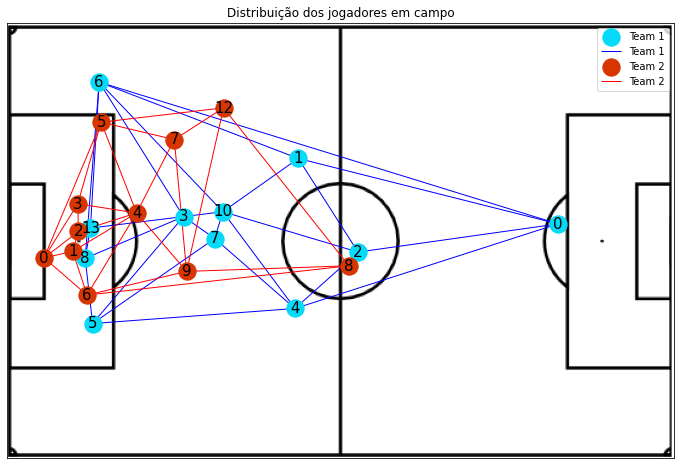

In [47]:
plot_generate(graph_list_BPI[28], 0,1,0)

In [40]:
def generate_graph_video(BPI):
    generate_imagens_to_ffmpeg(BPI)

In [41]:
#generate_imagens_to_ffmpeg(60, edges=False)
#ffmpeg -f image2 -i img%d.png test.mp4

## Criando video a partir das imagens 

In [42]:
#generate_imagens_to_ffmpeg(60, edges=True)

In [43]:
path = 'ffmpeg_fetws/' # Caminho para salvar o video
create_video(path, 60, edges=True) # Salvando o video usando ffmpeg

True


AttributeError: module 'ffmpeg' has no attribute 'input'